<a href="https://colab.research.google.com/github/rshlomi/Integration-Project/blob/main/SNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SNN

Spiking neural network, based on the paper:
<cite> [Jason K. Eshraghian, Max Ward, Emre Neftci, Xinxin Wang, Gregor Lenz, Girish Dwivedi, Mohammed Bennamoun, Doo Seok Jeong, and Wei D. Lu. "Training Spiking Neural Networks Using Lessons From Deep Learning".
arXiv preprint arXiv:2109.12894, September 2021.](https://arxiv.org/abs/2109.12894) </cite>
as well as the accompanying [tutorials](https://snntorch.readthedocs.io/en/latest/tutorials/index.html).

Imports

In [9]:
!pip install snntorch

import snntorch as snn # main snntorch package
import torch # PyTorch
import torch.nn as nn # for Linear and Loss
from torch.utils.data import DataLoader # for loading MNIST data
from torchvision import datasets, transforms
from numpy import mean
import matplotlib.pyplot as plt
from google.colab import drive # get images from Google Drive
from PIL import Image # show image on screen

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Network Architecture

In [10]:
side = 28
num_inputs = side * side
num_hidden = 500 # neurons in hidden layer
num_outputs = 10 # one for each digit

# Temporal Dynamics
num_steps = 20
beta = 0.95 # decay coefficient (fraction of membrane potential to be carried over to next time step)

# Define a transform to be applied to MNIST dataset
transform = transforms.Compose([
            transforms.Resize((side, side)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Get the static MNIST dataset (handwritten digits), often used for benchmarking neural networks
batch_size = 128
mnist_train = datasets.MNIST('/data/mnist', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('/data/mnist', train=False, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

# Class and function definitions

In [11]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.linear1 = nn.Linear(num_inputs, num_hidden) # input layer
        self.lif1 = snn.Leaky(beta=beta) # leaky integrate-and-fire
        self.linear2 = nn.Linear(num_hidden, num_outputs) # apply a linear transformation
        self.lif2 = snn.Leaky(beta=beta) # output layer

    def forward(self, x):

        # Membrabe potentials
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # output lists
        spk2_rec = []
        mem2_rec = []

        step = 0
        while step < num_steps:
            current = self.linear1(x)
            spk1, mem1 = self.lif1(current, mem1) # Use output from first layer as input to second layer
            current = self.linear2(spk1)
            spk2, mem2 = self.lif2(current, mem2) # Use output from third layer as input to fourth layer
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            step += 1

        # convert list of tensors to one tensor
        spikes = torch.stack(spk2_rec, dim=0)
        mem_potentials = torch.stack(mem2_rec, dim=0)
        return spikes, mem_potentials
        
# pass data into the network, 
# and compare the neuron with the highest number of spikes
# with the target

def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1)) # resize data and pass into SNN
    s1 = output.sum(dim=0) # sum the spikes over time
    _, idx = s1.max(1) # don't need first argument (max value); second is the index of the max

    acc = 1 - mean((targets != idx).detach().cpu().numpy())
    tt = "Train" if train else "Test"
    print(f"{tt} set accuracy for a single minibatch: {acc*100:.2f}%")

def accuracy_loss_monitor():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {train_loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)

def load_display_id(path: str, device=torch.device("cpu")) -> int:
  """Load image file from path, display it,
  transform it as above, feed it to network, and return result"""
  
  if path[-3:] == 'png' or path[-4:] == 'jpeg':
    try:
      with open(path, 'rb') as f:
        img = Image.open(f)
        img = img.convert("L") # 8-bit pixels, black and white
    except:
      print("Could not load image")
      return -1
    display(img)
    img = transform(img) # Defined above for MNIST set
    img = img[None, :] # match input dimensions to network
    img = img.to(device)
    net.eval() # make sure we're in evaluation (rather than training) mode
    spk, _ = net(img.view(img.size(0), -1))
    spk = spk.sum(dim=0)
    _, idx = spk.max(1)
    return idx[0].numpy().astype(int) # convert to plain (non-array) int
  else:
    print("Invalid image format: please use .png or .jpeg")
    return -2

# How does network perform on Test set?
def test_accuracy(dataset, device=torch.device("cpu")):
  total = 0
  corrects = 0

  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                          drop_last=False) # keep all samples

  with torch.no_grad():
    net.eval() # make sure we're in evaluation (rather than training) mode
    for data, targets in loader: # go over each batch
      data = data.to(device)
      targets = targets.to(device)
      
      # run the calibrated SNN (forward) to get output spike
      test_spk, _ = net(data.view(data.size(0), -1)) # only need spikes, not membrane potential

      # calculate total accuracy
      spike_sum = test_spk.sum(dim=0) # sum up spikes
      _, predicted = spike_sum.max(1) # get ouput index of max
      correct = (predicted == targets)
      correct = correct.sum()
      corrects += correct.item() # convert to scalar and add to tally
      total += targets.size(0)

  print(f"Total correctly classified test set images: {corrects}/{total}")
  print(f"Test Set Accuracy: {100 * corrects / total:.2f}%")    

# Train the network

In [12]:
num_epochs = 1 # number of times to use ALL of the data
train_loss_hist = []
test_loss_hist = []
counter = 0
print_freq = 100 # how often to print results
torch_zero = torch.zeros((1), dtype=torch.float, device=device) # loss initialization
silent = False # set to True to not see monitoring
device = torch.device("cpu") # hardware

# Instantiate the class and load the network onto CPU
net = Net().to(device)

"""The practical effect of choosing a **cross-entropy** loss function is that the membrane potential of the correct ouput (class) is "encouraged" to increase,
while all of the others are reduced."""
loss = nn.CrossEntropyLoss(reduction="sum") # rather than mean reduction

# robust optimizer that performs well on recurrent networks
# (At this point, no justification to change default parameters)
optimizer = torch.optim.Adam(net.parameters())

# Outer training loop, for going over all of the data
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        _, mem_rec = net(data.view(batch_size, -1))

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=torch.float, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets) # cross-entropy defined ↑

        # Gradient calculation + weight update
        optimizer.zero_grad() # clear any previously stored gradients
        loss_val.backward() # compute the gradient of the loss tensor
        optimizer.step()

        # Store loss history (for plotting)
        train_loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))

            # Test set loss
            test_loss = torch.zeros((1), dtype=torch.float, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % print_freq == 0 and not silent:
              accuracy_loss_monitor()
            elif counter % print_freq == 1 and not silent:
              print("\n")
            else:
              pass
            counter += 1
            iter_counter +=1

print(f"Training loss decreased from {train_loss_hist[0]} to {train_loss_hist[-1]}")
print(f"and test loss decreased from {test_loss_hist[0]} to {test_loss_hist[-1]}")
print(f"over the course of {len(train_loss_hist)} iterations.")

Epoch 0, Iteration 0
Train Set Loss: 6079.66
Test Set Loss: 5378.05
Train set accuracy for a single minibatch: 55.47%
Test set accuracy for a single minibatch: 38.28%


Epoch 0, Iteration 100
Train Set Loss: 1113.92
Test Set Loss: 1181.00
Train set accuracy for a single minibatch: 89.84%
Test set accuracy for a single minibatch: 89.06%


Epoch 0, Iteration 200
Train Set Loss: 1081.48
Test Set Loss: 1237.10
Train set accuracy for a single minibatch: 88.28%
Test set accuracy for a single minibatch: 90.62%


Epoch 0, Iteration 300
Train Set Loss: 676.43
Test Set Loss: 729.04
Train set accuracy for a single minibatch: 92.19%
Test set accuracy for a single minibatch: 93.75%


Epoch 0, Iteration 400
Train Set Loss: 584.93
Test Set Loss: 765.18
Train set accuracy for a single minibatch: 93.75%
Test set accuracy for a single minibatch: 95.31%


Training loss decreased from 6079.66064453125 to 990.1646118164062
and test loss decreased from 5378.04736328125 to 460.1941833496094
over the course o

# Plot Loss evolution and gauge performance for Training data

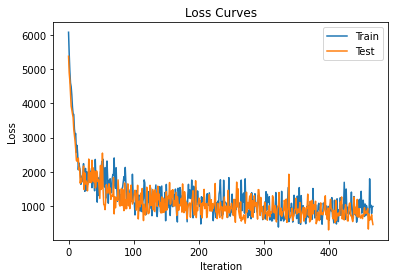

Total correctly classified test set images: 9260/10000
Test Set Accuracy: 92.60%


In [13]:
fig = plt.figure()
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train", "Test"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

test_accuracy(mnist_test)

# ID [.jpeg and .png] images outside of MNIST (e.g. from Google Drive, local machine)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


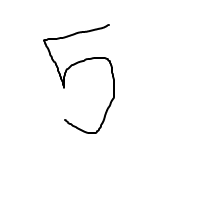

The digit detected is 3


In [14]:
# To upload from Google Drive:
drive.mount('/content/drive')
img_url = '/content/drive/MyDrive/Colab Notebooks/five_002.png'
#img_url = '/content/drive/MyDrive/Colab Notebooks/three001.jpeg'
#img_url = '/content/drive/MyDrive/Colab Notebooks/Seven_001.png'
#img_url = '/content/drive/MyDrive/Colab Notebooks/eight_001.png'

# To upload from local machine, choose "Upload to session storage" (left tab)
#img_url = '/eight_001.png'
result = load_display_id(img_url)
print(f"The digit detected is {result}")